In [62]:
import scipy.io as sio
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from pathlib import Path
from typing import Union, Any, Optional
from scipy.interpolate import griddata
from scipy.signal import find_peaks
import scipy.signal as signal
from matplotlib import cm
import seaborn as sns
import re
import os 

# inline plots
%matplotlib inline
sns.set()

def make_beta_cheby1_filter(fs, n, rp, low, high):
    """Calculate bandpass filter coefficients (1st Order Chebyshev Filter)"""
    nyq = 0.5 * fs
    lowcut = low / nyq
    highcut = high / nyq

    b, a = signal.cheby1(n, rp, [lowcut, highcut], "band")

    return b, a

def filter_lfp(lfp_signal, beta_b, beta_a):
    
    """Filter lfp_signal

    Inputs:
        lfp_signal          - window of LFP signal (samples)

        tail_length         - tail length which will be discarded due to
                              filtering artifact (samples)

        beta_b, beta_a      - filter coefficients for filtering the beta-band
                              from the signal
    """

    lfp_beta_signal = signal.filtfilt(beta_b, beta_a, lfp_signal)
    #lfp_beta_signal_rectified = np.absolute(lfp_beta_signal)
    #avg_beta_power = np.mean(lfp_beta_signal_rectified[-2 * tail_length : -tail_length])

    return lfp_beta_signal 

def load_stn_lfp(
        dir: Path,
        start_time: float,
        tot_time: float
        ) -> tuple[np.ndarray, dict]:
    '''Reads STN LFP data from a .mat file
    Modifications have been made for input parameters 
    start_time instead of stead_state_time and 
    total_time (stead_state_time + sim_time) instead of 
    sim_time'''
    lfp_file = sio.loadmat(dir / 'STN_LFP.mat')
    segments, _, _ = lfp_file['block'][0, 0]
    segment = mat_to_dict(segments[0, 0][0, 0])
    lfp = mat_to_dict(segment['analogsignals'][0, 0][0, 0])
    lfp_t = np.linspace(start_time , tot_time, len(lfp['signal']))
    return lfp_t, lfp


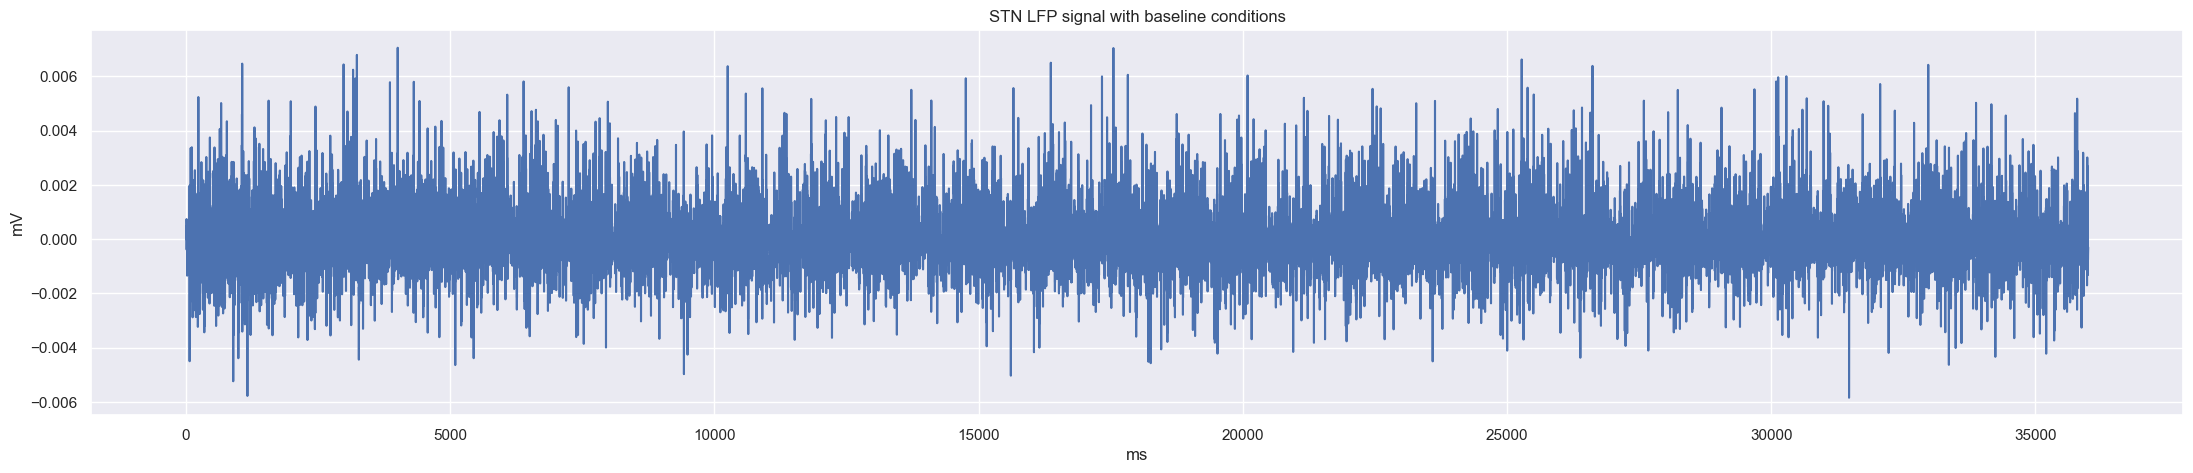

In [63]:
# Plotting results from the zero controler configuration
dir = Path('../Results_30s/RESULTS_baseline_30s')
lfp_t, lfp = load_stn_lfp(dir, 0, 36000)

plt.figure(figsize=(27, 5))
plt.plot(lfp_t, lfp["signal"][:,0])
plt.xlabel('ms')
plt.ylabel('mV')
plt.title('STN LFP signal with baseline conditions')
plt.show()

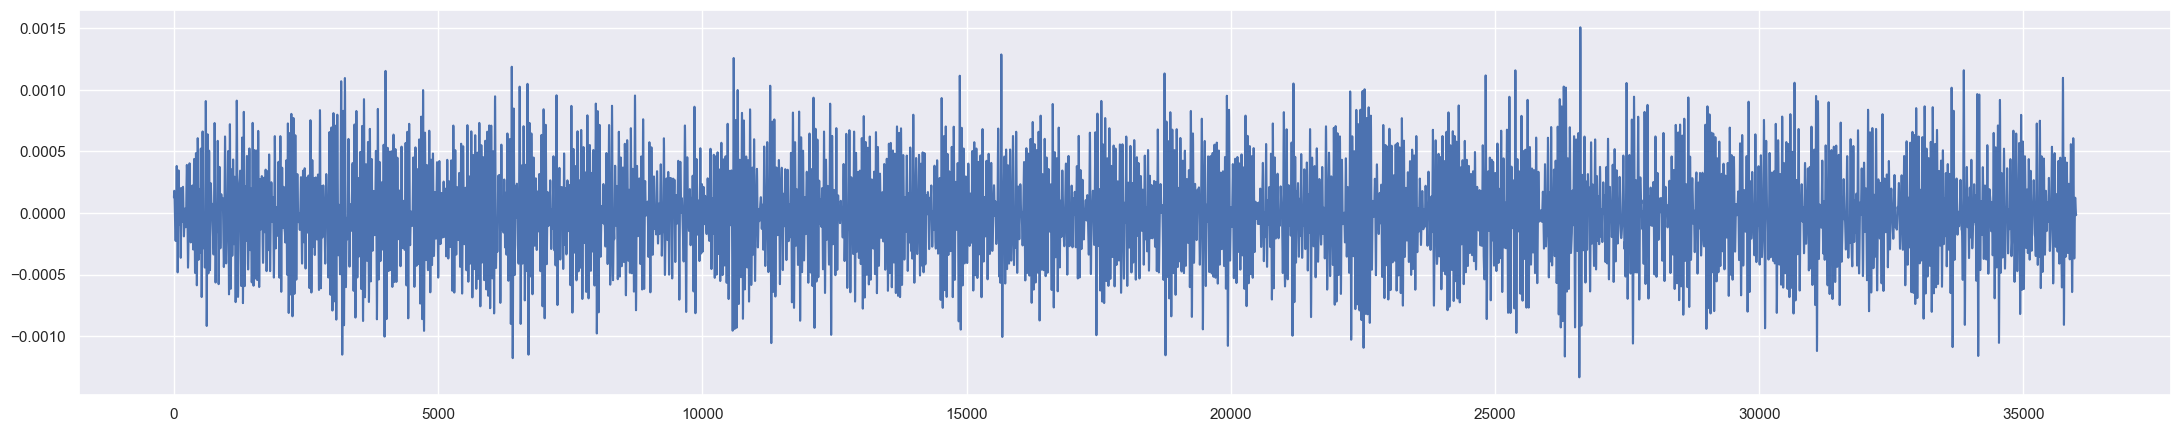

[0.00000000e+00 4.90469897e-01 9.80939795e-01 ... 3.59990191e+04
 3.59995095e+04 3.60000000e+04]


In [64]:
rec_sampling_interval = 0.5 #in milliseconds
fs = 1000.0 / rec_sampling_interval

# Baseline signal after band pass filtering ( 13 Hz - 35 Hz) (as in the manuscript)
beta_b, beta_a = make_beta_cheby1_filter(fs=fs, n=4, rp=0.5, low=13, high=35)
lfp_beta_signal = filter_lfp(lfp["signal"][:,0], beta_b, beta_a)

plt.figure(figsize=(27, 5))
plt.plot(lfp_t, lfp_beta_signal)
plt.show()
print(lfp_t)

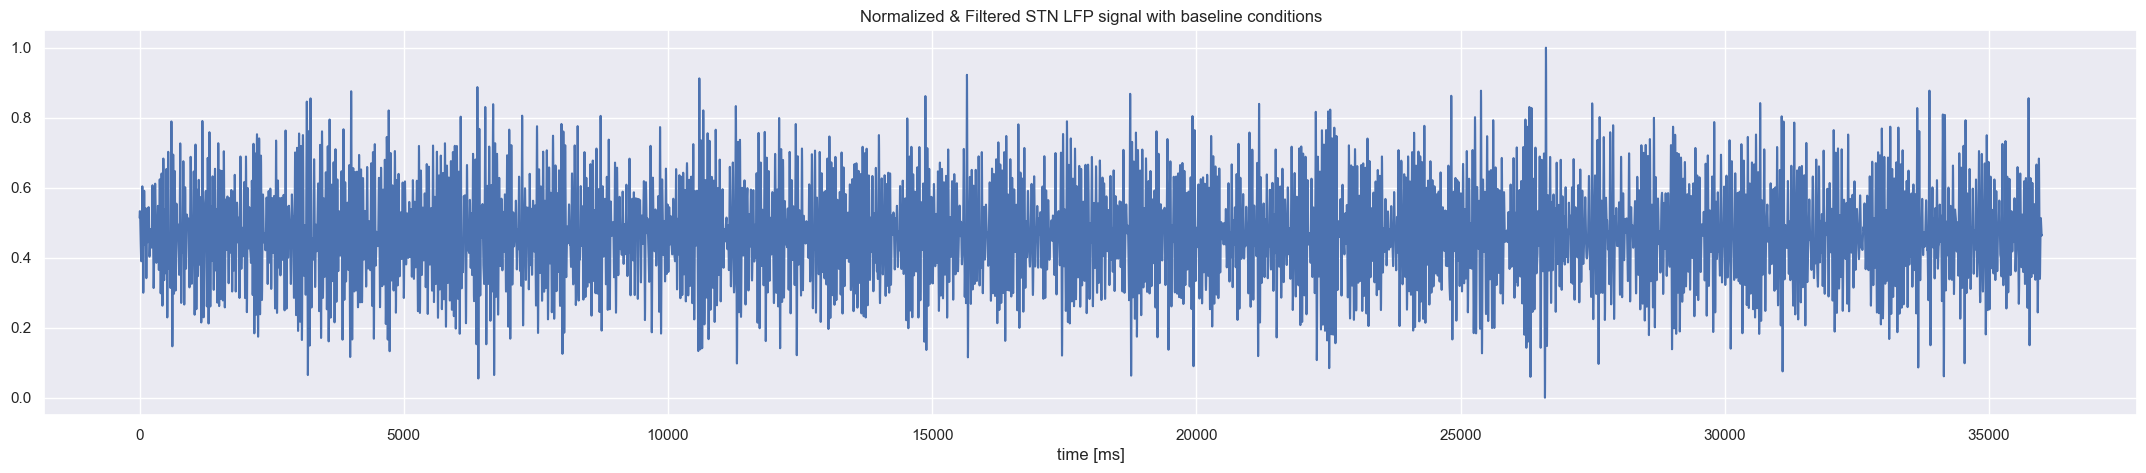

In [65]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:    
        return x
    
# Normalize signal to better eyeball the threshold for peaks 
norm_signal = normalize_range(lfp_beta_signal)
plt.figure(figsize=(27, 5))
plt.plot(lfp_t, norm_signal)
plt.title("Normalized & Filtered STN LFP signal with baseline conditions")
plt.xlabel("time [ms]")
plt.show()

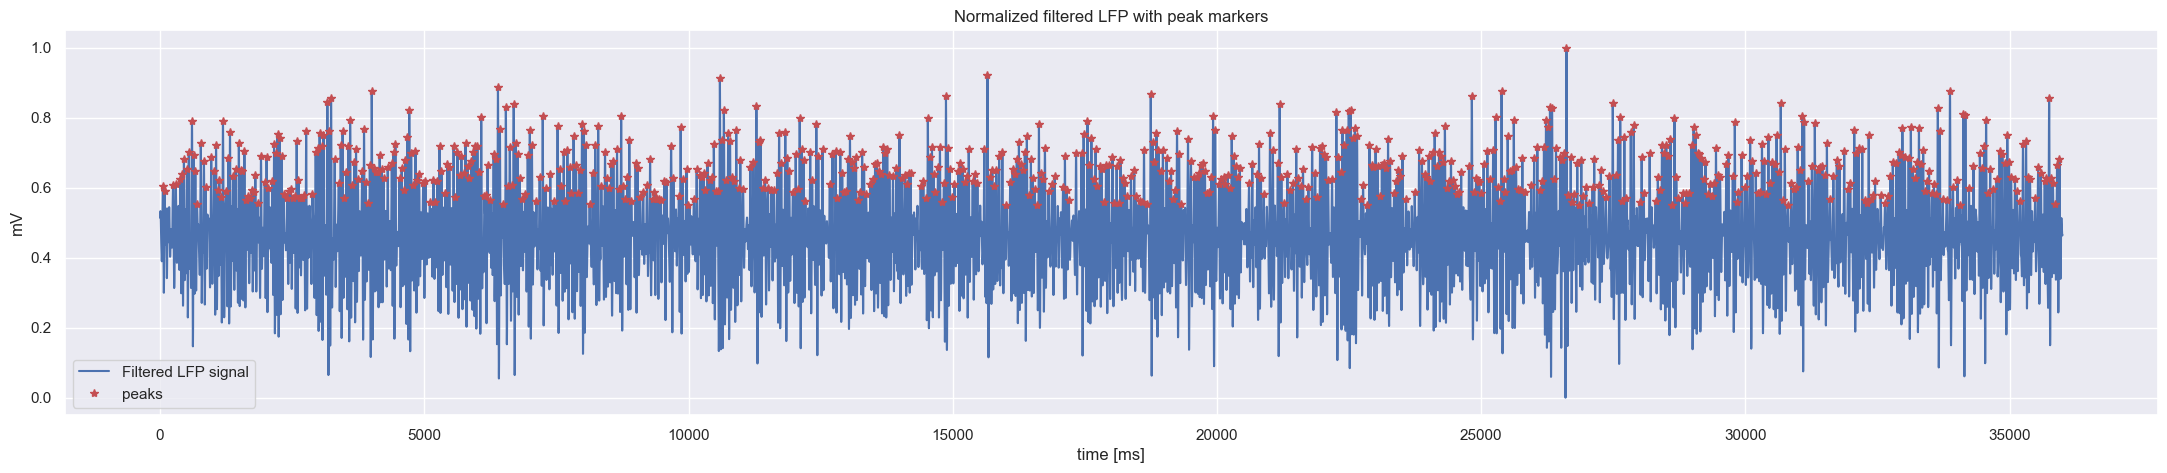

[0.00000000e+00 4.90469897e-01 9.80939795e-01 ... 3.59990191e+04
 3.59995095e+04 3.60000000e+04]


In [66]:
threshold = 0.55

peaks, properties = signal.find_peaks(norm_signal, threshold)
h_peaks = properties['peak_heights']

# Printing the time for each peak 
t_peaks =  1000*peaks/2038.9 # 2000 Hz should be the sampling frequency

plt.figure(figsize=(27, 5))
plt.plot(lfp_t, norm_signal, "b", t_peaks, h_peaks, "r*" )
plt.title("Normalized filtered LFP with peak markers")
plt.xlabel("time [ms]")
plt.ylabel("mV")
plt.legend(["Filtered LFP signal", "peaks"], loc='lower left') 
plt.show()
print(lfp_t)

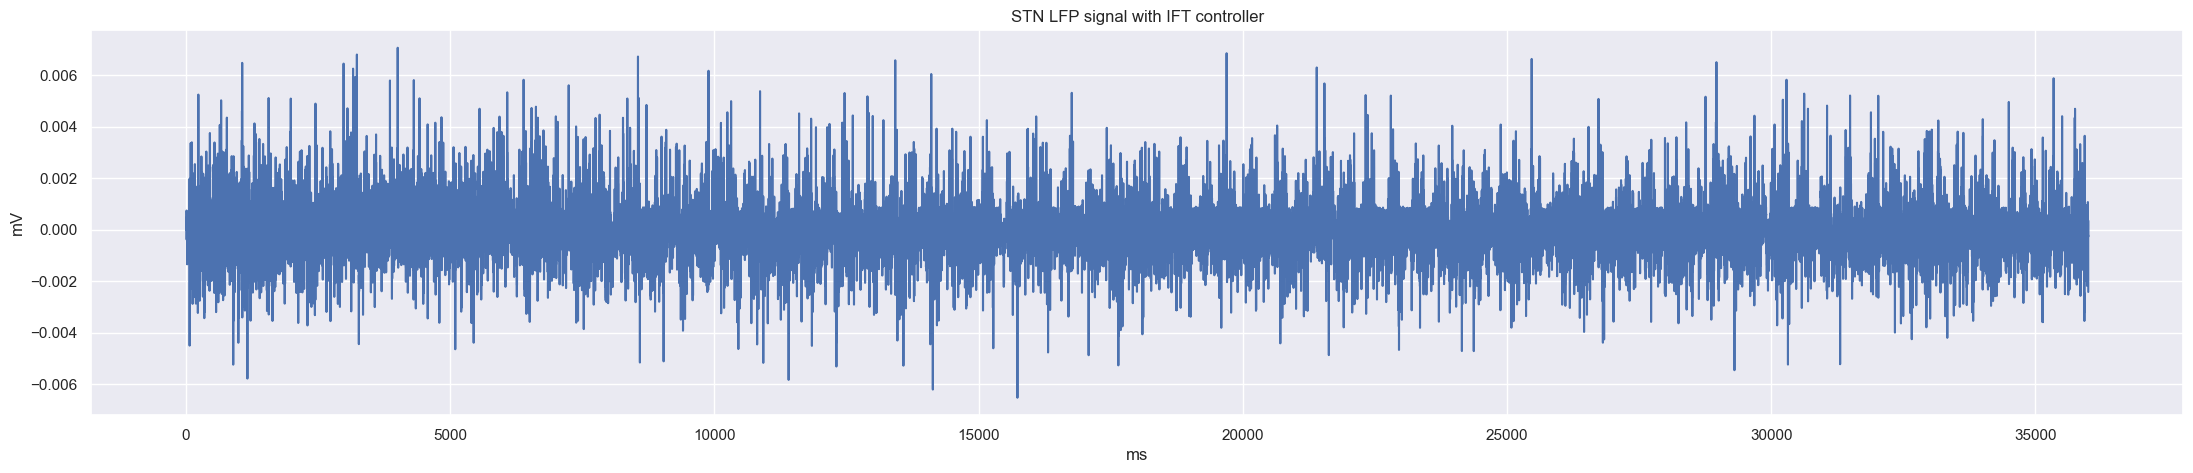

In [67]:
# Plotting results from the IFT frequency modulation controler configuration
dir2 = Path('../Results_30s/RESULTS_IFT_30s')
lfp_t, lfp = load_stn_lfp(dir2, 0, 36000)

plt.figure(figsize=(27, 5))
plt.plot(lfp_t, lfp["signal"][:,0])
plt.xlabel('ms')
plt.ylabel('mV')
plt.title('STN LFP signal with IFT controller')
plt.show()

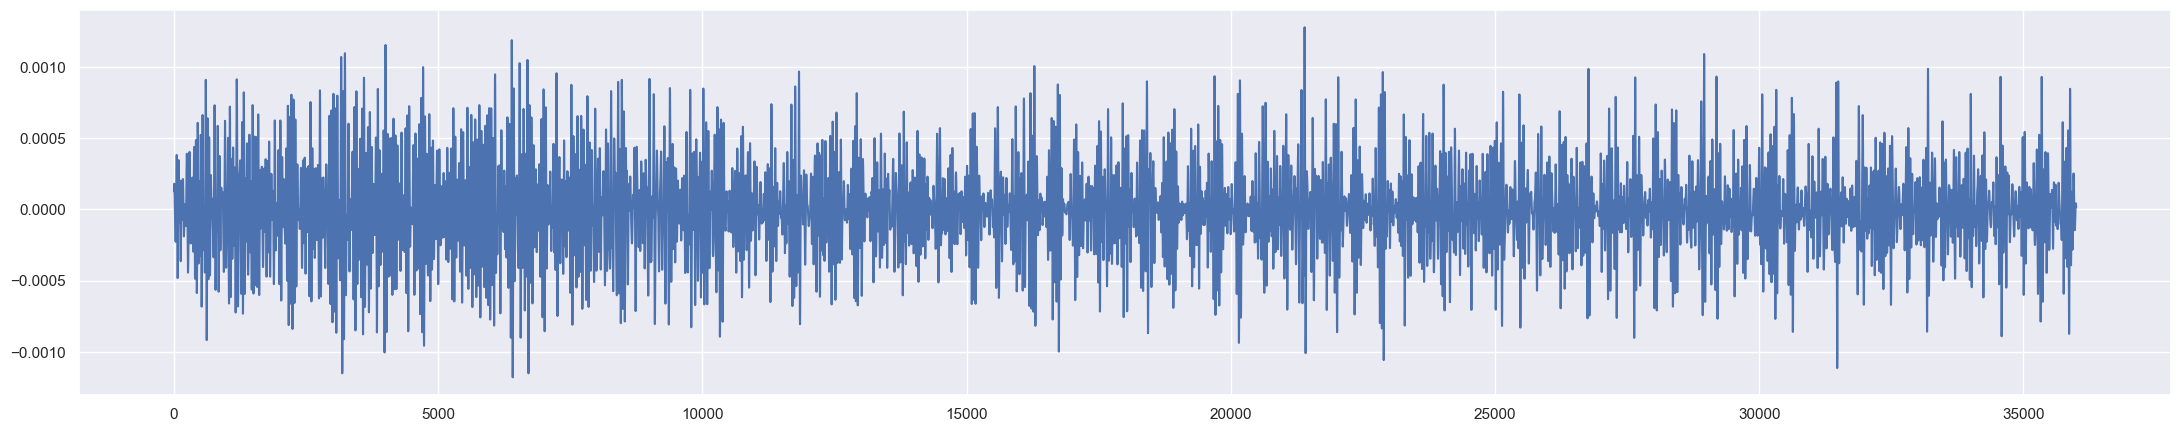

[0.00000000e+00 4.90469897e-01 9.80939795e-01 ... 3.59990191e+04
 3.59995095e+04 3.60000000e+04]


In [68]:
# IFT signal after band pass filtering ( 13 Hz - 35 Hz) (as in the manuscript)
lfp_beta_signal = filter_lfp(lfp["signal"][:,0], beta_b, beta_a)

plt.figure(figsize=(27, 5))
plt.plot(lfp_t, lfp_beta_signal)
plt.show()
print(lfp_t)

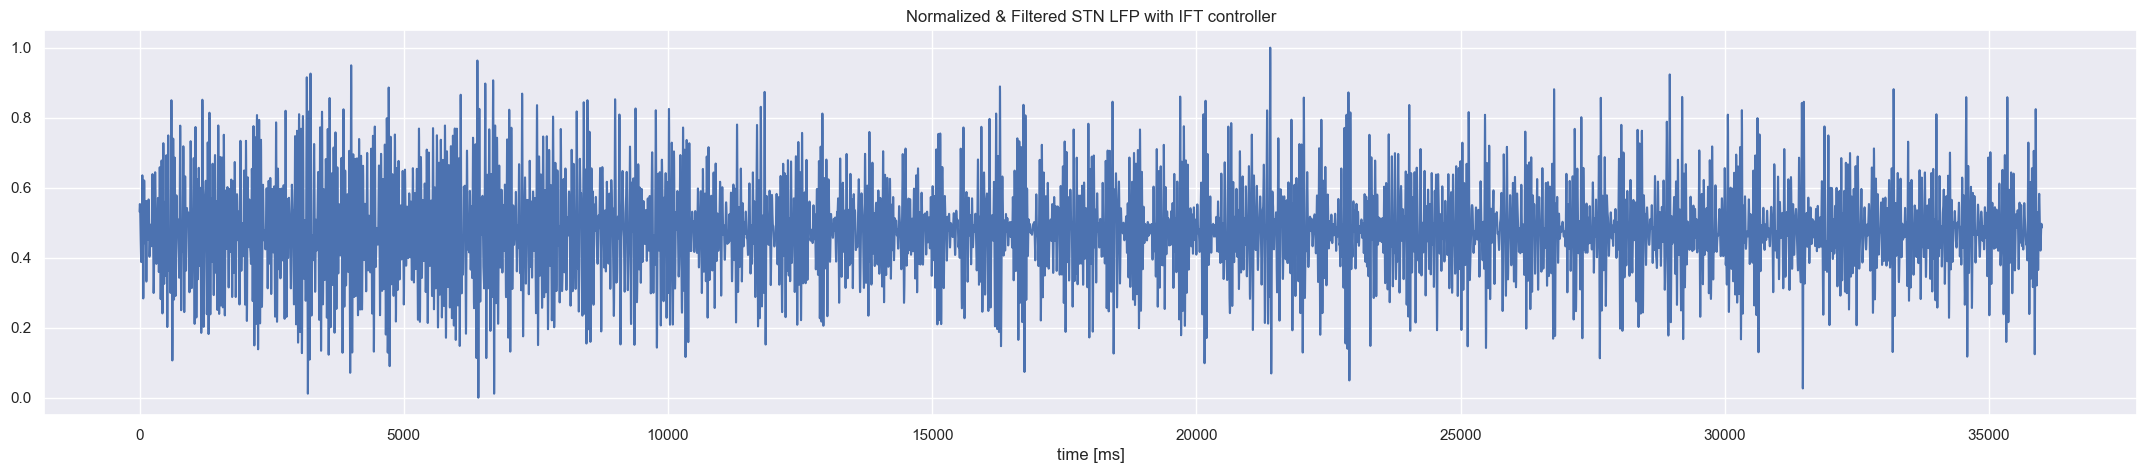

In [69]:

# Normalize signal to better eyeball the threshold for peaks 
norm_signal = normalize_range(lfp_beta_signal)
plt.figure(figsize=(27, 5))
plt.plot(lfp_t, norm_signal)
plt.title("Normalized & Filtered STN LFP with IFT controller")
plt.xlabel("time [ms]")
plt.show()

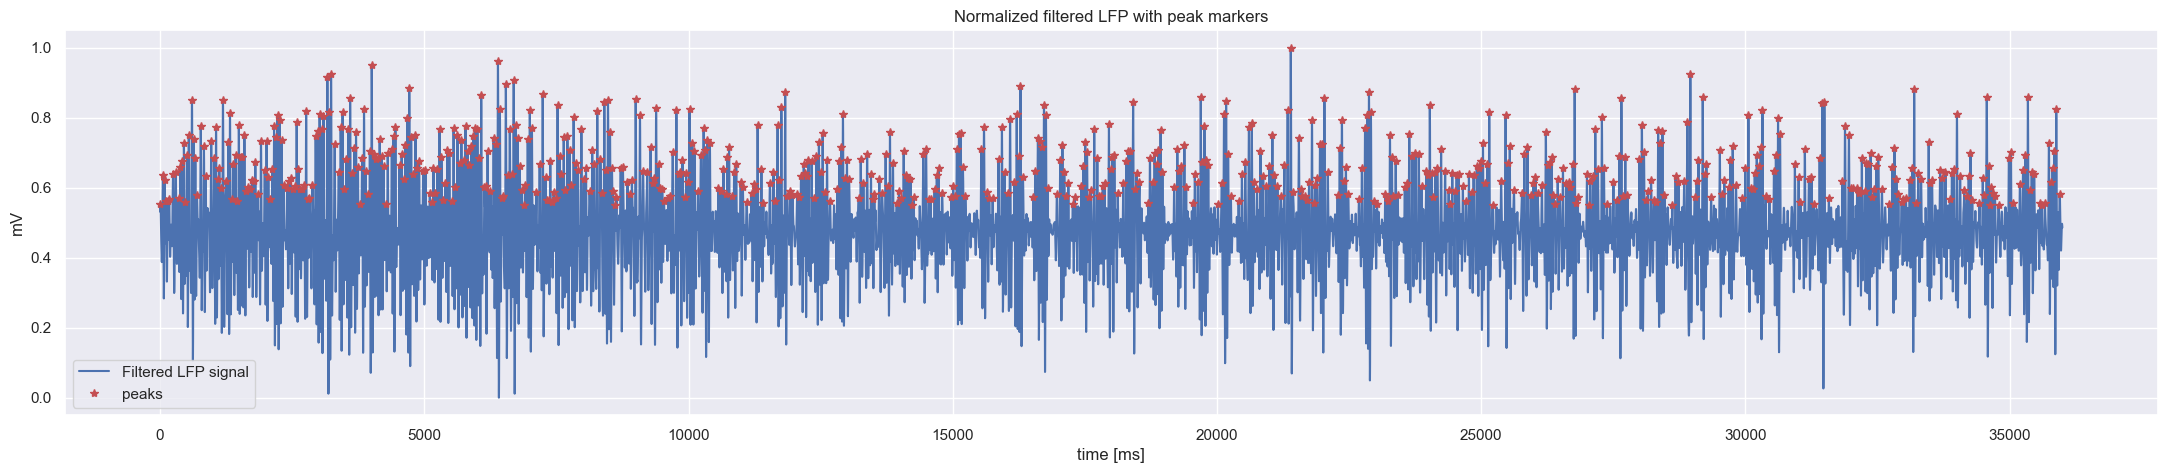

[0.00000000e+00 4.90469897e-01 9.80939795e-01 ... 3.59990191e+04
 3.59995095e+04 3.60000000e+04]


In [70]:
threshold = 0.55

peaks, properties = signal.find_peaks(norm_signal, threshold)
h_peaks = properties['peak_heights']

# Printing the time for each peak 
t_peaks =  1000*peaks/2038.9 # 2000 Hz should be the sampling frequency

plt.figure(figsize=(27, 5))
plt.plot(lfp_t, norm_signal, "b", t_peaks, h_peaks, "r*" )
plt.title("Normalized filtered LFP with peak markers")
plt.xlabel("time [ms]")
plt.ylabel("mV")
plt.legend(["Filtered LFP signal", "peaks"], loc='lower left') 
plt.show()
print(lfp_t)

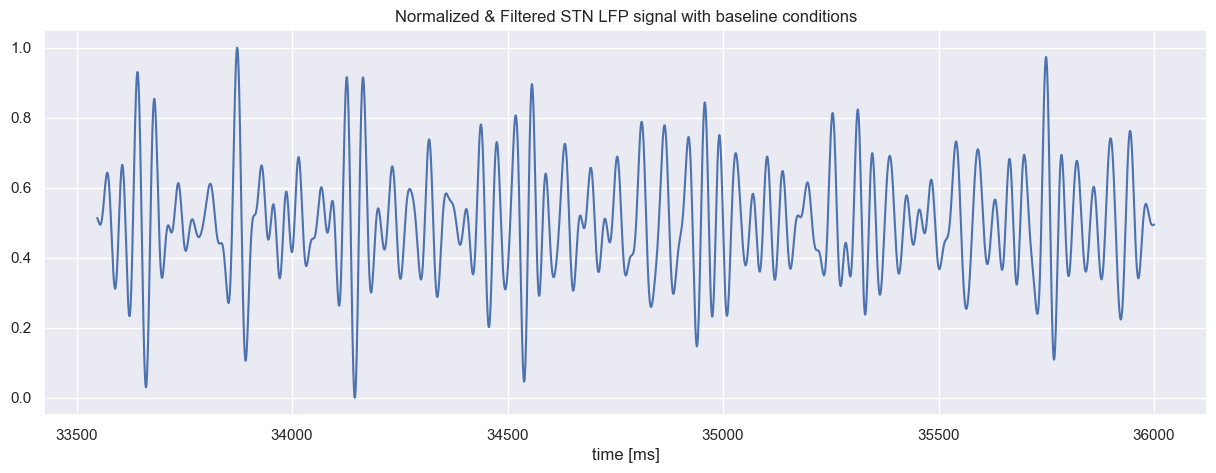

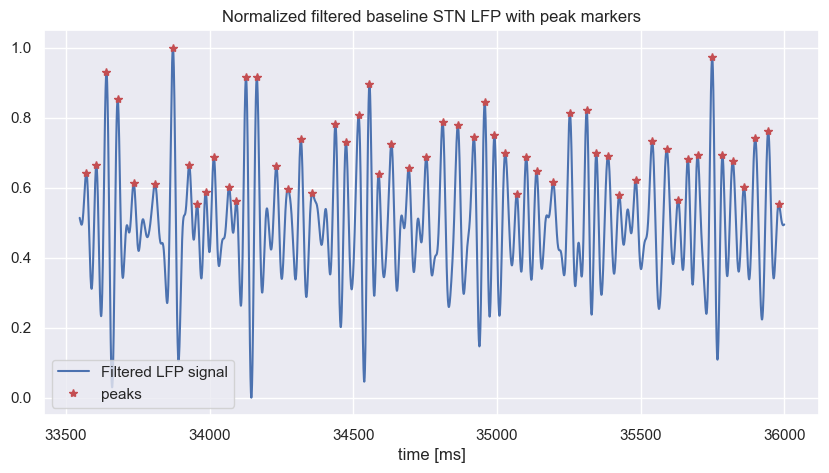

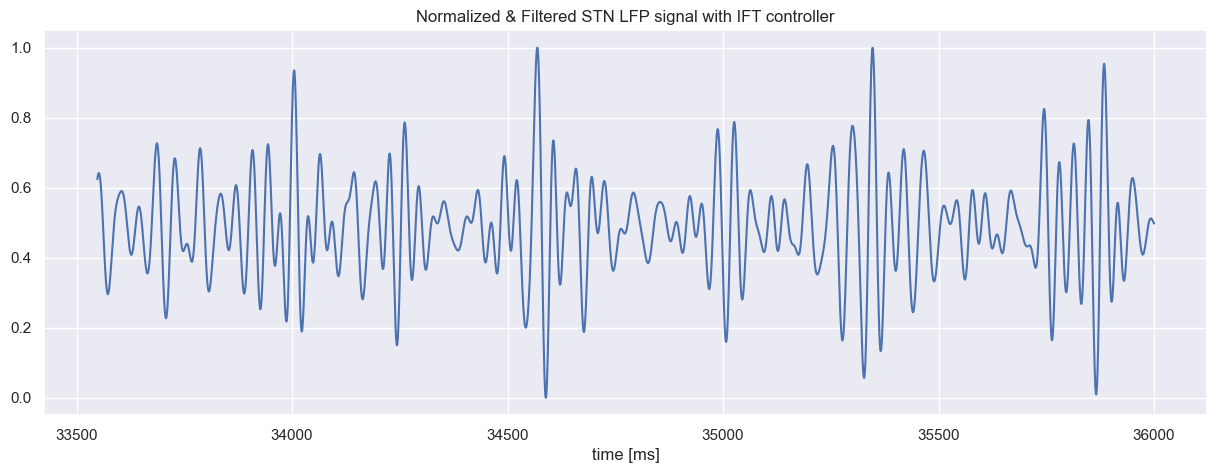

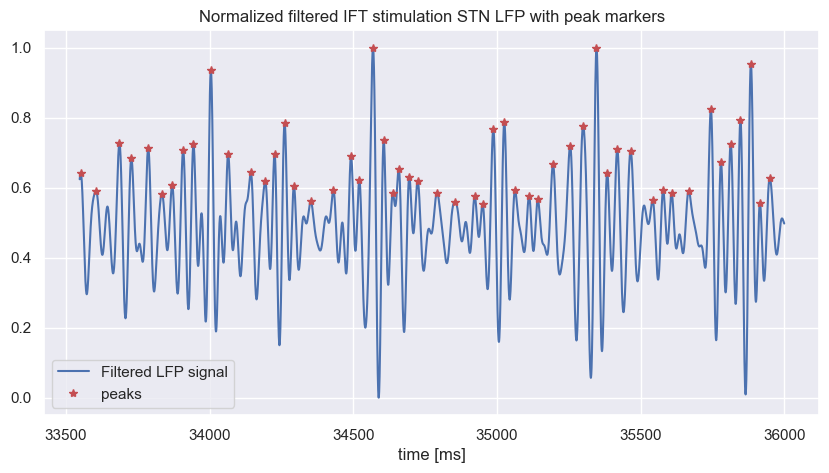

In [72]:
# Same plots with smaller windows
window = 5000

# Baseline 
dir = Path('../Results_30s/RESULTS_baseline_30s')
lfp_t, lfp = load_stn_lfp(dir, 0, 36000)
lfp_beta_signal = filter_lfp(lfp["signal"][-window:,0], beta_b, beta_a)
norm_signal = normalize_range(lfp_beta_signal)

plt.figure(figsize=(15, 5))
plt.plot(lfp_t[-window:], norm_signal)
plt.title("Normalized & Filtered STN LFP signal with baseline conditions")
plt.xlabel("time [ms]")
plt.show()

threshold = 0.55

peaks, properties = signal.find_peaks(norm_signal, threshold)
h_peaks = properties['peak_heights']

# Printing the time for each peak 
t_peaks = lfp_t[-window] + 1000*peaks/2038.9 # 2000 Hz should be the sampling frequency

plt.figure(figsize=(10, 5))
plt.plot(lfp_t[-window:], norm_signal, "b", t_peaks, h_peaks, "r*" )
plt.title("Normalized filtered baseline STN LFP with peak markers")
plt.xlabel("time [ms]")
plt.legend(["Filtered LFP signal", "peaks"], loc='lower left') 
plt.show()


# IFT signal after band pass filtering ( 13 Hz - 35 Hz) (as in the manuscript)
dir2 = Path('../Results_30s/RESULTS_IFT_30s')
lfp_t, lfp = load_stn_lfp(dir2, 0, 36000)
lfp_beta_signal = filter_lfp(lfp["signal"][-window:,0], beta_b, beta_a)
norm_signal = normalize_range(lfp_beta_signal)

plt.figure(figsize=(15, 5))
plt.plot(lfp_t[-window:], norm_signal)
plt.title("Normalized & Filtered STN LFP signal with IFT controller")
plt.xlabel("time [ms]")
plt.show()

threshold = 0.55

peaks, properties = signal.find_peaks(norm_signal, threshold)
h_peaks = properties['peak_heights']

# Printing the time for each peak 
t_peaks = lfp_t[-window] + 1000*peaks/2038.9 # 2000 Hz should be the sampling frequency

plt.figure(figsize=(10, 5))
plt.plot(lfp_t[-window:], norm_signal, "b", t_peaks, h_peaks, "r*" )
plt.title("Normalized filtered IFT stimulation STN LFP with peak markers")
plt.xlabel("time [ms]")
plt.legend(["Filtered LFP signal", "peaks"], loc='lower left') 
plt.show()